<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/notebooks/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/segment_data.zip
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/data_old.zip

!wget https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/unet.py

Mounted at /content/drive
--2021-09-20 00:28:44--  https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/unet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4449 (4.3K) [text/plain]
Saving to: ‘unet.py’

unet.py             100%[===================>]   4.34K  --.-KB/s    in 0s      

2021-09-20 00:28:44 (38.9 MB/s) - ‘unet.py’ saved [4449/4449]



In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Input
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.densenet import preprocess_input

import unet

### Visualize training data

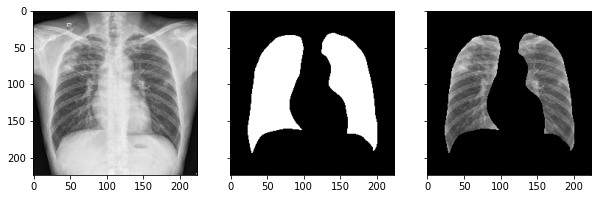

In [3]:
images_path = os.path.join('segment_data', 'images')
masks_path = os.path.join('segment_data', 'masks')

images_list = os.listdir(images_path)
images_list.sort()
masks_list = os.listdir(masks_path)
masks_list.sort() 

index = random.randint(0, len(images_list))
image_path = os.path.join(images_path, images_list[index])
mask_path = os.path.join(masks_path, masks_list[index])
image = load_img(image_path)
image = img_to_array(image)
mask = load_img(mask_path, color_mode='grayscale')
mask = img_to_array(mask)

f, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
axes[0].imshow(image/255.)
axes[1].imshow(np.squeeze(mask)/255., cmap='gray')
axes[2].imshow((image/255.) * (mask/255), cmap='gray')

### Build X and y from image files

Images need to be preprocessed in the same manner as the preprocessing for Densenet. Masks will be 0 or 1, so simply divided by 255. 

In [4]:
n_samples = len(images_list)
X = np.zeros((n_samples, 224, 224, 3))
y = np.zeros((n_samples, 224, 224, 1))
for i, fn in enumerate(images_list):
  image_path = os.path.join(images_path, fn)
  image = load_img(image_path)
  image = img_to_array(image)
  #image = preprocess_input(image)
  image /= 255.
  X[i] = image

  mask_path = os.path.join(masks_path, masks_list[i])
  mask = load_img(mask_path, color_mode='grayscale')
  mask = img_to_array(mask) / 255.
  y[i] = mask

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.1)
X_train.shape, X_test.shape

((633, 224, 224, 3), (71, 224, 224, 3))

### Build the model

In [ ]:
input_shape = (224, 224, 3)
model = unet.build_unet(input_shape, 4)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Compile and train

In [ ]:
model.compile(optimizer='adam', loss=unet.get_dice_loss(), metrics=[unet.dice_coeff])
stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, 
                    y_train, 
                    batch_size=8, 
                    epochs=100,
                    callbacks=[stop],
                    validation_data=(X_test, y_test),
                    validation_steps=1,
                    verbose=1)

Epoch 1/100
80/80 [==============================] - 112s 925ms/step - loss: 0.1517 - dice_coeff: 0.8492 - val_loss: 0.5324 - val_dice_coeff: 0.4676
Epoch 2/100
80/80 [==============================] - 71s 885ms/step - loss: 0.0633 - dice_coeff: 0.9363 - val_loss: 0.9888 - val_dice_coeff: 0.0112
Epoch 3/100
80/80 [==============================] - 70s 881ms/step - loss: 0.0495 - dice_coeff: 0.9506 - val_loss: 0.9959 - val_dice_coeff: 0.0041
Epoch 4/100
80/80 [==============================] - 70s 881ms/step - loss: 0.0540 - dice_coeff: 0.9463 - val_loss: 0.9978 - val_dice_coeff: 0.0022
Epoch 5/100
80/80 [==============================] - 70s 881ms/step - loss: 0.0450 - dice_coeff: 0.9551 - val_loss: 0.1183 - val_dice_coeff: 0.8817
Epoch 6/100
80/80 [==============================] - 70s 881ms/step - loss: 0.0424 - dice_coeff: 0.9570 - val_loss: 0.0502 - val_dice_coeff: 0.9498
Epoch 7/100
80/80 [==============================] - 71s 882ms/step - loss: 0.0400 - dice_coeff: 0.9600 - val_l

### Evaluation

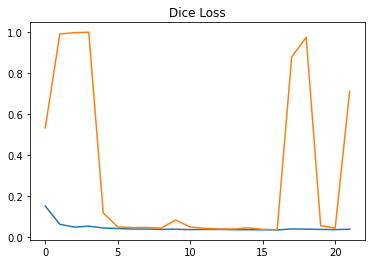

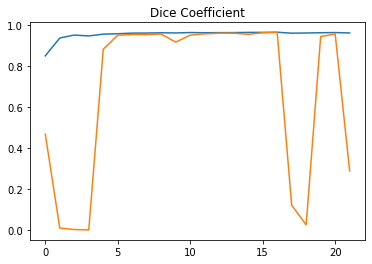

In [ ]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Dice Loss')
plt.show()

plt.plot(history.history['dice_coeff'], label='Training')
plt.plot(history.history['val_dice_coeff'], label='Validation')
plt.title('Dice Coefficient')
plt.show()


In [ ]:
y_preds = model.predict(X_test, verbose=1)
y_preds = K.cast(y_preds, 'double')
dice = unet.dice_coeff(y_test, y_preds).numpy()
print(f'Dice coefficient for test: {round(dice * 100, 2)}%')

3/3 [==============================] - 17s 2s/step
Dice coefficient for test: 96.18%


In [ ]:
model_path = os.path.join(BASE_PATH, 'alt_segment_model.h5')
model.save(model_path)
weights_path = os.path.join(BASE_PATH, 'alt_segment_weights.hdf5')
model.save_weights(weights_path)

In [5]:
model_path = os.path.join(BASE_PATH, 'alt_segment_model.h5')
model = load_model(model_path, compile=False)

### Crop and zoom for ROI

In [49]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class MergeZoom(Layer):
    def __init__(self, threshold=0.5, **kwargs):
        self.threshold = threshold
        super(MergeZoom, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({'threshold': self.threshold})
        return config

    def build(self, input_shape):
        super(MergeZoom, self).build(input_shape)

    def call(self, inputs):
        image_shape = inputs[1].shape[1:]
        cropped = tf.map_fn(self.crop_images, 
                            inputs,
                            fn_output_signature=tf.TensorSpec(image_shape))
        return cropped

    def crop_images(self, inputs):
        mask, image = inputs
        mask = K.greater_equal(mask, self.threshold)
        mask = K.cast(mask, 'float32')

        if tf.reduce_all(mask == 0):
            return image

        x = tf.reduce_any(mask != 0, axis=0)
        x = tf.cast(x, tf.int8)
        y = tf.reduce_any(mask != 0, axis=1)
        y = tf.cast(y, tf.int8)

        xl, xr = self.find_edges(x)
        yl, yr = self.find_edges(x)

        cropped = mask[yl:yr, xl:xr, :] * image[yl:yr, xl:xr, :]
        cropped = tf.image.resize(cropped, 
                                  (image.shape[0], image.shape[1]),
                                  preserve_aspect_ratio=True)
        return cropped

    def find_edges(self, x):
        xl = 0
        xr = 0
        i = 0
        while K.equal(xl, 0):
            xl = tf.cond(x[i,0] > 0, lambda: i-5, lambda: xl)
            i += 1
    
        i = len(x) - 1
        while K.equal(xr, 0):
            xr = tf.cond(x[i,0] > 0, lambda: i+5, lambda: xr)
            i -= 1

        return xl, xr

In [ ]:
from tensorflow.keras.layers import Lambda, Multiply

In [50]:
for layer in model.layers:
  layer.trainable = False

input_layer = model.layers[0]
image_in = input_layer.output

x = model.output
#threshed = Lambda(thresh, arguments={'threshold': 0.5})(x)
#outputs = Multiply()([threshed, image_in])
outputs = MergeZoom()([x, image_in])

model2 = Model(inputs=model.input, outputs=[outputs, x])
model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [7]:
y = model2.predict(X_train, batch_size=8, verbose=1)


80/80 [==============================] - 73s 473ms/step


In [8]:
y[0].shape

(633, 224, 224, 3)

### Choose random example and compare masking via model vs. ground truth

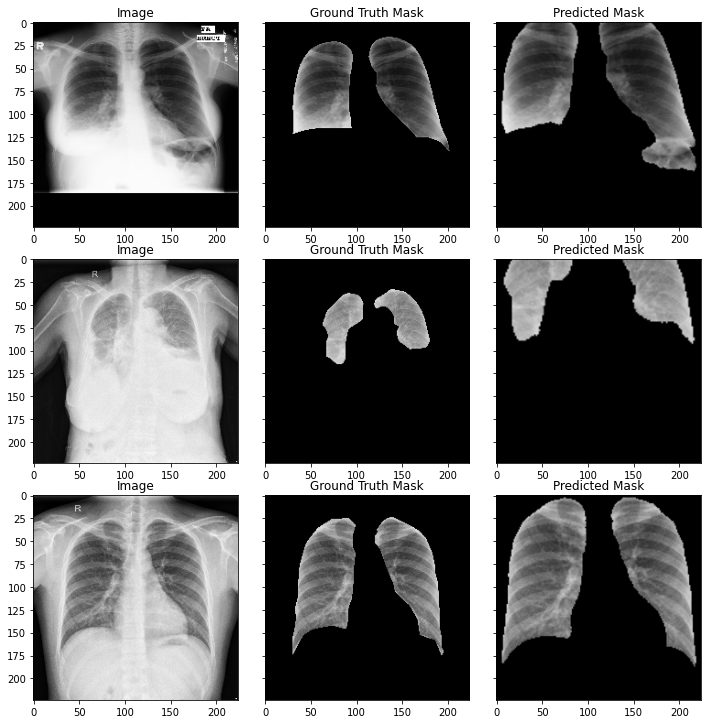

In [55]:
indexes = random.sample(range(len(images_list)), 3)

images = []
orig_masks = []


for j in range(3):
  image_path = os.path.join(images_path, images_list[indexes[j]])
  mask_path = os.path.join(masks_path, masks_list[indexes[j]])

  image = load_img(image_path)
  images.append(img_to_array(image))

  orig_mask = load_img(mask_path, color_mode='grayscale')
  orig_masks.append(img_to_array(orig_mask))

images = K.stack(images)
orig_masks = K.stack(orig_masks)

#x = preprocess_input(images)
x = images / 255.
y, masks = model2.predict(x)


f, axes = plt.subplots(3, 3, sharey=True, figsize=(10, 10))
plt.tight_layout()

for j in range(3):
  axes[j][0].imshow(images[j] / 255.)
  axes[j][0].set_title('Image')
  axes[j][1].imshow((images[j] / 255.) * (orig_masks[j]/255.))
  axes[j][1].set_title('Ground Truth Mask')
  axes[j][2].imshow(y[j])
  axes[j][2].set_title('Predicted Mask')
plt.show()

### Visually test with other dataset

In [ ]:
new_images_path = os.path.join('data', 'test', 'normal')

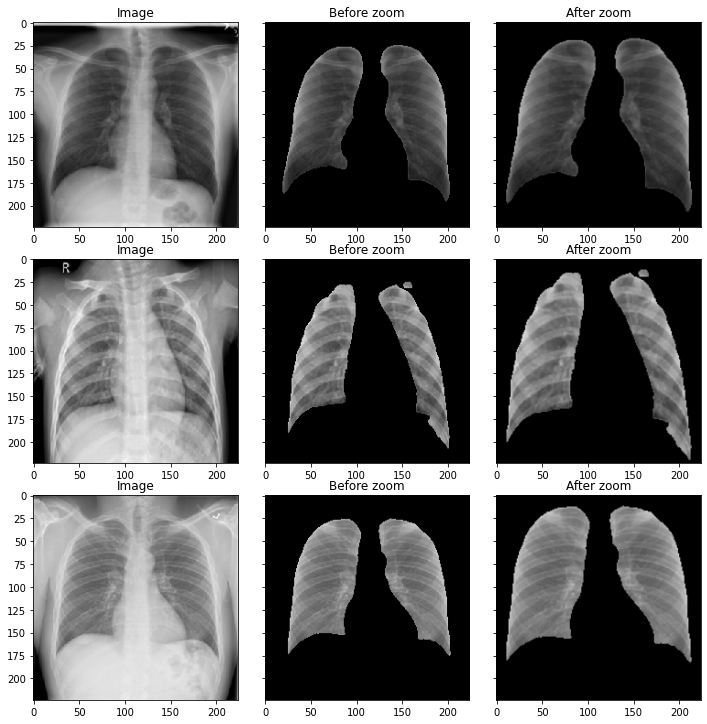

In [ ]:
new_images_list = os.listdir(new_images_path)
indexes = random.sample(range(len(new_images_list)), 3)

images = []

for j in range(3):
  new_image_path = os.path.join(new_images_path, new_images_list[indexes[j]])
  image = load_img(new_image_path, target_size=(224, 224))
  images.append(img_to_array(image))

images = K.stack(images)

x = images / 255.
y, mask = model2.predict(x)
mask = (mask >= 0.5).astype(np.float32)

f, axes = plt.subplots(3, 3, sharey=True, figsize=(10, 10))
plt.tight_layout()

for j in range(3):
  axes[j][0].imshow(images[j] / 255.)
  axes[j][0].set_title('Image')

  axes[j][1].imshow(images[j] * mask[j] / 255.)
  axes[j][1].set_title('Before zoom')
 
  axes[j][2].imshow(y[j])
  axes[j][2].set_title('After zoom')
plt.show()